# Defining gapfill media (vol. 3)

This part builds on the reconstruction with soft constraints. The models selected from that process are further used here. 


Strategy:
- **Make media based on..**
    - **product prediction of models able to grow**
    - **Filter by CHEBI class**

In [6]:
import pandas as pd
import reframed
import os
import json
import copy

import functions.translation_dicts as translation_dicts
import functions.general_functions as general_func

In [7]:
compounds_dict, source_dict,substrate_dict, gas_sheet_dict, community_dict = translation_dicts.translation_dicts()

**Load data**

In [8]:
MAG2community_id= pd.read_csv("output/MAG2community_id.tsv",sep="\t",header=None,index_col=0)
MAG2community_id.columns=["community_id"]

In [9]:
all_mags_paper = general_func.read_allmags_data()
all_mags_paper.head(2)

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.1,Compost_Digestate,Xylan,99.37,0.32,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora amygdalina_A,5147597.0,48.0,197896.0,4902.0,CH14-bin.1,54.707294
CH14-bin.2,Compost_Digestate,Xylan,99.37,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Robinsoniella,Robinsoniella peoriensis,5647052.0,70.0,172899.0,4618.0,CH14-bin.2,18.831114


**Load models made without soft constraints**

In [10]:
directory = os 

directory = os.fsencode("output/GEMs/GEMs_adapt/")

GEMs_dict = {}
for file in os.listdir(directory):
    
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        print(filename)
        GEMs_dict[filename[:-4]]= reframed.load_cbmodel("output/GEMs/GEMs_adapt/"+filename)


CH7-bin.18.xml
CH15-bin.7.xml
CH13-bin.0.xml
CH1-bin.4.xml
CH13-bin.1.xml
CH13-bin.11.xml
CH15-bin.6.xml
CH7-bin.2.xml
CH13-bin.13.xml
CH1-bin.10.xml
CH1-bin.6.xml
CH13-bin.2.xml
CH13-bin.12.xml
CH15-bin.5.xml
CH7-bin.1.xml
CH15-bin.1.xml
CH1-bin.3.xml
CH13-bin.17.xml
CH15-bin.0.xml
CH7-bin.4.xml
CH7-bin.23.xml
CH7-bin.6.xml
CH15-bin.22.xml
CH15-bin.2.xml
CH1-bin.1.xml
CH13-bin.4.xml
CH13-bin.14.xml
CH15-bin.23.xml
CH7-bin.20.xml
CH8-bin.8.xml
CH8-bin.9.xml
CH8-bin.25.xml
CH14-bin.4.xml
CH14-bin.1.xml
CH8-bin.21.xml
CH14-bin.2.xml
CH8-bin.22.xml
CH8-bin.2.xml
CH8-bin.29.xml
CH8-bin.7.xml
CH8-bin.6.xml
CH3-bin.2.xml
CH8-bin.14.xml
CH8-bin.16.xml
CH3-bin.0.xml
CH8-bin.5.xml
CH3-bin.1.xml
CH8-bin.17.xml
CH7-bin.11.xml
CH9-bin.1.xml
CH15-bin.12.xml
CH13-bin.25.xml
CH15-bin.13.xml
CH9-bin.0.xml
CH7-bin.12.xml
CH9-bin.2.xml
CH7-bin.9.xml
CH15-bin.10.xml
CH7-bin.8.xml
CH7-bin.13.xml
CH7-bin.17.xml
CH15-bin.8.xml
CH15-bin.15.xml
CH7-bin.16.xml
CH9-bin.6.xml
CH9-bin.4.xml
CH15-bin.17.xml
CH1-bi

### Define environment

**From SynCon2 to SynCon1**

"SynCon2 had the same composition, but it lacked ascorbic acid, and it had two additional trace elements (selenium and wolfram)"

Add
- Ascorbate: ascb__L

Remove
- Selenite (inorganic selenium): slnt
- (wolfram: not in BiGG database)

In [11]:
syncon2 = list(pd.read_csv("input/syncon2media_combined.csv",header=None)[0].values)

syncon1 = copy.copy(syncon2)
syncon1.remove("slnt")
syncon1.append("ascb__L")

**The different experiments had different polysaccharides as carbon sources**

In [12]:
substrate_composition = {"A":["cellb","cell3","cell4","cell5"], # Avicel
                         "P":["cellb","cell3","cell4","cell5"], # PASC
                         "X":["xylb","xyl3","xylan4","xylan8"]} # Xylan

**Create media for each carbon source**

In [13]:
syncon1_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon1_environments[substrate_name]= reframed.Environment.from_compounds(syncon1)
    for met in met_mols:
        syncon1_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

In [14]:
syncon2_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon2_environments[substrate_name]= reframed.Environment.from_compounds(syncon2)
    for met in met_mols:
        syncon2_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

### Determine abundance


**Get 99% most abundant species (>1%)**

In [18]:
relevant_MAGs = list(all_mags_paper[all_mags_paper["new_coverage"]>1].index)

In [19]:
len(relevant_MAGs)

72

## Modify Environment to support community growth

### FBA growth predictions (SynCon2)

In [20]:
community_groups = MAG2community_id.groupby(by="community_id").groups

In [21]:
FBA_growth = {}
for community_id, MAGs in community_groups.items(): 
    FBA_growth[community_id]={}
    for MAG in MAGs:
        if MAG in relevant_MAGs:
            print(MAG)
            model = GEMs_dict[MAG]
            syncon2_environments[community_id.split("_")[1]].apply(model,inplace=True,exclusive=True)
            sol = reframed.FBA(model)

            if sol is None:
                FBA_growth[community_id][MAG]=None
            else:
                FBA_growth[community_id][MAG]=sol

CH13-bin.12
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14
CH13-bin.11


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_btn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cellb_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1
CH14-bin.2
CH14-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/

CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH3-bin.2
CH3-bin.1
CH3-bin.0


In [22]:
# Add the source and substrate to this data
growth_community_df = pd.concat([MAG2community_id,pd.Series({GEM:sol.fobj for community_id,GEM_sol_dict in FBA_growth.items() for GEM,sol in GEM_sol_dict.items()})],axis=1)
# Change from float to False or positive
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)
# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

**When considering all community members all but Cow_Manure on xylan have a growing community member**

In [23]:
growth_groupby = growth_community_df

growth_groupby.groupby("community_id").value_counts()

community_id  Grows
CD_A          False    18
              True      1
CD_P          False    18
              True      2
CD_X          False     2
              True      1
CM_A          False    16
              True      3
CM_P          False    15
              True      4
CM_X          False     7
M_P           False    10
              True      1
M_X           False     2
              True      1
Name: count, dtype: int64

**When considering top 99 of members all but Cow_Manure on xylan have a growing community member**

In [25]:
growth_groupby = growth_community_df[growth_community_df.index.isin(all_mags_paper[all_mags_paper["new_coverage"]>1].index)]

growth_groupby.groupby("community_id").value_counts()

community_id  Grows
CD_A          False     9
              True      1
CD_P          False    13
              True      2
CD_X          False     2
              True      1
CM_A          False    10
              True      3
CM_P          False    11
              True      4
CM_X          False     6
M_P           False     6
              True      1
M_X           False     2
              True      1
Name: count, dtype: int64

In [26]:
MAG_can_grow = growth_community_df[growth_community_df.Grows].index

### FVA prediction of bacteria that can survive in the media (SynCon2) at obj_frac=0

1. Find compounds produced by growing community members
2. Filter by CHEBI class

#### Run FVA and find produced compounds

**Run FVA for exchange reactions of growing community members**

In [27]:
FVA_production = {}

for community_id, MAGs in community_groups.items(): 
    
    FVA_production[community_id]={}
    
    for MAG in MAGs:
        
        # If MAG is among the ones who cannot grow -> continue
        if MAG not in MAG_can_grow:
            continue
        print(MAG)
        
        
        model = GEMs_dict[MAG]
        
        # Apply medium
        syncon2_environments[community_id.split("_")[1]].apply(model,inplace=True,exclusive=True)
        # Find FVA solution and obj_frac=0
        FVA_production[community_id][MAG] = reframed.FVA(model,reactions=model.get_exchange_reactions(),obj_frac=0.0)
        

CH13-bin.2


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_btn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ni2_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/env

CH15-bin.22


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_nac_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cell3_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cell5_e
  warn(f'Exchange reaction not in model: {r_id}')


CH15-bin.16
CH14-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_mobd_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.17
CH8-bin.6


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.14


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')


CH7-bin.16


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cell4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH7-bin.2
CH7-bin.1
CH7-bin.20
CH1-bin.8
CH3-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')


**Find compounds that are being produced**

In [28]:
FVA_production_copy = FVA_production.copy()
FVA_production_copy = {community:{MAG:[rxn for rxn,sol in FVA_production_copy[community][MAG].items() if sol[1]>1e-6] for MAG in FVA_production_copy[community].keys()}
                       for community in FVA_production_copy.keys()}

**Combine the results from each community member into community level**

In [29]:
community_prod = {community_name:[] for community_name in FVA_production_copy.keys()}


for community_name,mag_prod in FVA_production_copy.items():
    for MAG,rxns in mag_prod.items():
        community_prod[community_name].extend(rxns)
    
    community_prod[community_name] = list(set(community_prod[community_name]))

In [30]:
community_prod

{'CD_A': ['R_EX_h_e',
  'R_EX_co2_e',
  'R_EX_glyc3p_e',
  'R_EX_gal_e',
  'R_EX_dhptd_e',
  'R_EX_LalaDgluMdapDala_e',
  'R_EX_2obut_e',
  'R_sink_mobd_c',
  'R_EX_rib__D_e',
  'R_EX_mal__L_e',
  'R_EX_4hba_e',
  'R_EX_h2o_e',
  'R_EX_5mdru1p_e',
  'R_EX_acglu_e',
  'R_EX_ocdcea_e',
  'R_EX_ppap_e',
  'R_EX_anhgm_e',
  'R_EX_quin_e',
  'R_EX_succ_e',
  'R_EX_pheme_e',
  'R_EX_o2_e',
  'R_EX_g3pg_e',
  'R_EX_glyc_e',
  'R_EX_thym_e',
  'R_EX_spmd_e',
  'R_EX_coa_e',
  'R_EX_nh4_e',
  'R_EX_5drib_e',
  'R_EX_m4po_e',
  'R_EX_pac_e',
  'R_EX_glc__D_e',
  'R_EX_fad_e',
  'R_EX_h2s_e',
  'R_EX_gua_e',
  'R_EX_lac__L_e',
  'R_EX_ura_e',
  'R_EX_ac_e',
  'R_EX_inost_e',
  'R_EX_asp__D_e',
  'R_EX_thm_e',
  'R_EX_acald_e',
  'R_EX_LalaDgluMdap_e',
  'R_EX_alaala_e',
  'R_sink_2ohph_c'],
 'CD_P': ['R_EX_glyald_e',
  'R_EX_h_e',
  'R_EX_co2_e',
  'R_sink_oxam_c',
  'R_EX_LalaDgluMdapDala_e',
  'R_EX_dha_e',
  'R_EX_ibt_e',
  'R_sink_mobd_c',
  'R_EX_pacald_e',
  'R_EX_mal__L_e',
  'R_EX_rib__D_

#### Filter by chebi_class

In [31]:
# Some compounds are not interesting for us when it comes to exchange
ignore_classes = ["other","inorganic ion","oligopeptide","monosaccharide","cellodextrin","carbohydrate derivative","carbohydrate acid","nonmetal atom"]

In [32]:
met_chebi_class = pd.read_csv("output/met_chebi_class.tsv",sep="\t",index_col=0)

met_chebi_class_dict = met_chebi_class["chebi class"].to_dict()

community_prod_dfs = {community_name: pd.DataFrame({"rxns":rxns,
                                                   "chebi_class":[met_chebi_class_dict["M_"+rxn[5:]] if "M_"+rxn[5:] in met_chebi_class_dict.keys() else "other" for rxn in rxns]}) 
                      for community_name,rxns in community_prod.items()}

In [33]:
for community_name,df in community_prod_dfs.items():
    community_prod_dfs[community_name] = community_prod_dfs[community_name][~community_prod_dfs[community_name].chebi_class.isin(ignore_classes)]

#### Plot data

In [34]:
community_prod_count_dfs ={}

for community_name, df in community_prod_dfs.items():
    
    community_prod_count_dfs[community_name] = df.groupby("chebi_class").count()

<Axes: ylabel='chebi_class'>

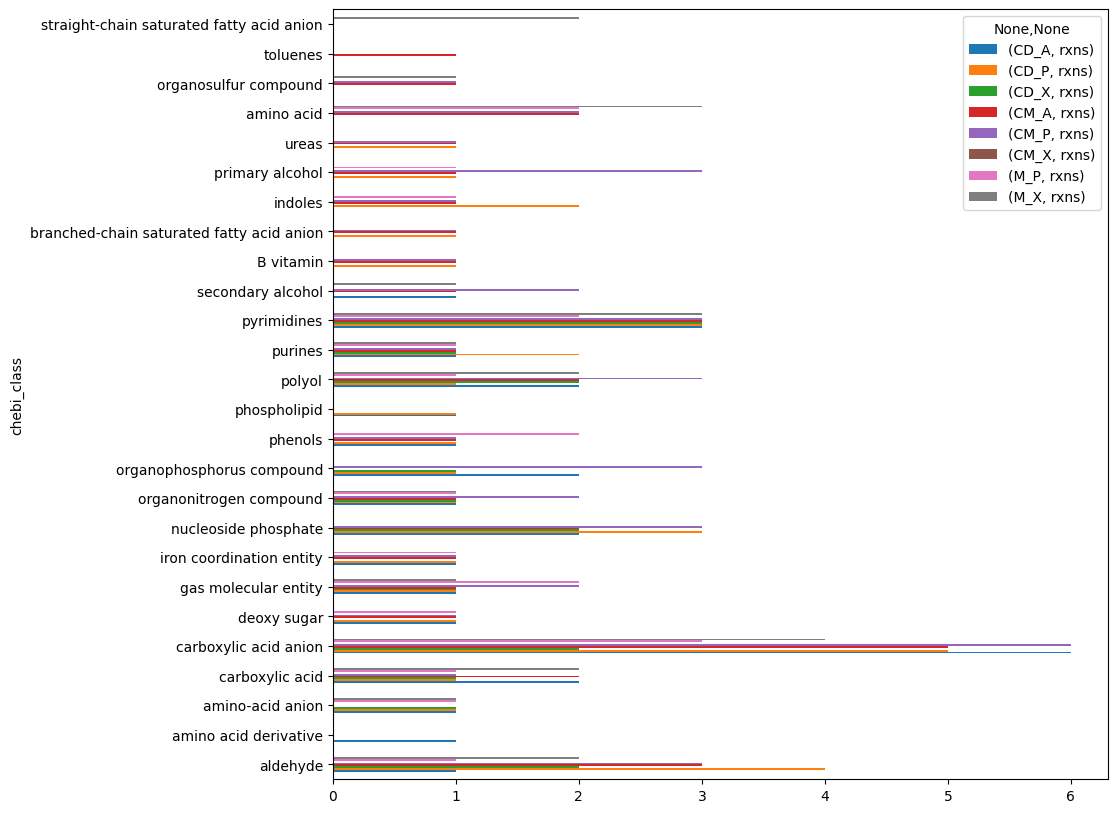

In [35]:
pd.concat(community_prod_count_dfs,axis=1).fillna(0).plot(kind="barh",figsize=(10,10))

### Make new environments

In [36]:
substrate_monosaccharides = {"X":"xyl__D","A":"glc__D","P":"glc__D"}
substrate_dict = {'X': 'Xylan', 'A': 'Avicel', 'P': 'PASC'}
source_dict = {'M':'Marshland soil','CD':'Compost and Digestate', 'CM':'Cow manure'}

In [37]:
model_uni = reframed.load_cbmodel("/Users/idunmariaburgos/universal_model_extension/output/universe_bacteria.xml")

In [38]:
syncon2_media = {}
for community_id,df in community_prod_dfs.items():
    mets = [rxn[5:-2] for rxn in df.rxns.values]
    mets.extend(syncon2)
    
    substrate = community_id.split("_")[1]
    mets.extend(substrate_composition[substrate])
    mets.append(substrate_monosaccharides[substrate])
    
    syncon2_media[community_id]=set(mets)

In [39]:
media_dfs = []

for community_id,compounds in syncon2_media.items():
    media_id_list = community_id.split("_")

    source = media_id_list[0]
    substrate = media_id_list[1]

    # NB! Some of the compounds they used are not in the universal model!
    compounds = [met for met in compounds if "M_"+met+"_e" in model_uni.metabolites]
    compounds_names = [model_uni.metabolites["M_"+met+"_e"].name for met in compounds]
    
    media_df = pd.DataFrame({"medium":[community_id for met in compounds],
               "description": ["Media + produced compounds in "+source_dict[source]+" on " +substrate_dict[substrate] for met in compounds],
               "compound":compounds,
               "name":compounds_names})
    media_dfs.append(media_df)

In [40]:
pd.concat(media_dfs).to_csv("output/gapfill_media/gapfill_media.tsv",sep="\t",index=None)

In [41]:
media_total_df = pd.concat(media_dfs)
media_total_df

,medium,description,compound,name
0,CD_A,Media + produced compounds in Compost and Dige...,cys__L,L-Cysteine
1,CD_A,Media + produced compounds in Compost and Dige...,g3pg,Glycerophosphoglycerol
2,CD_A,Media + produced compounds in Compost and Dige...,thm,Thiamin
3,CD_A,Media + produced compounds in Compost and Dige...,zn2,Zinc
4,CD_A,Media + produced compounds in Compost and Dige...,thym,Thymine C5H6N2O2
...,...,...,...,...
51,M_X,Media + produced compounds in Marshland soil o...,pnto__R,(R)-Pantothenate
52,M_X,Media + produced compounds in Marshland soil o...,mg2,Magnesium
53,M_X,Media + produced compounds in Marshland soil o...,4abz,4-Aminobenzoate
54,M_X,Media + produced compounds in Marshland soil o...,pta,Pentanoate
